<font size="6"><b>MLP Neural Networks - Part III</b></font>

# Libraries

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
import datetime, warnings, scipy
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D , SeparableConv2D, MaxPool2D, Flatten , Dropout , BatchNormalization
from keras.layers import Dense
from sklearn import preprocessing
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# Data Loading

In [2]:
dfm_ready = pd.read_csv('dfm_ready.csv', index_col=0)
dfm_ready.head().append(dfm_ready.tail())

,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,ARR_DELAY,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,DAY,FLIGHT_STATUS,OP_CARRIER_Allegiant Air,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_Frontier Airlines,OP_CARRIER_Hawaiian Airlines,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_Republic Airways,OP_CARRIER_SkyWest Airlines,OP_CARRIER_Southwest Airlines,OP_CARRIER_Spirit Airlines,OP_CARRIER_United Airlines,OP_CARRIER_Virgin America,DEST_Atlanta,DEST_Boston,DEST_Charlotte,DEST_Chicago,DEST_Dallas-Fort Worth,DEST_Denver,DEST_Detroit,DEST_Houston,DEST_Las Vegas,DEST_Los Angeles,DEST_Minneapolis,DEST_New York,DEST_Newark,DEST_Orlando,DEST_Philadelphia,DEST_Phoenix,DEST_Salt Lake City,DEST_San Francisco,DEST_Seattle,CRS_DEP_TIME_2,CRS_DEP_TIME_3,CRS_DEP_TIME_4,CRS_ARR_TIME_2,CRS_ARR_TIME_3,CRS_ARR_TIME_4,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,-5.0,15.0,3,3,10.0,-23.0,268.0,225.0,1605.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-8.0,11.0,2,3,7.0,-24.0,99.0,65.0,414.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-5.0,15.0,3,3,5.0,-13.0,134.0,106.0,846.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6.0,19.0,3,3,6.0,-2.0,190.0,157.0,1120.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,-3.0,14.0,2,2,6.0,-16.0,206.0,173.0,1222.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7213439,31.0,12.0,4,4,6.0,9.0,182.0,142.0,1303.0,31,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7213440,-1.0,12.0,3,3,4.0,-23.0,84.0,46.0,331.0,31,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7213441,-4.0,20.0,3,3,7.0,-5.0,100.0,72.0,331.0,31,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7213442,6.0,18.0,4,4,10.0,1.0,181.0,148.0,936.0,31,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7213445,8.0,8.0,3,3,7.0,-4.0,71.0,44.0,130.0,31,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [3]:
dfm_ready.drop(['TAXI_OUT','WHEELS_OFF','WHEELS_ON','DAY','TAXI_IN','ARR_DELAY'], axis=1, inplace=True)

In [4]:
df = dfm_ready.astype(float)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3982067 entries, 0 to 7213445
Data columns (total 64 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   DEP_DELAY                      float64
 1   CRS_ELAPSED_TIME               float64
 2   AIR_TIME                       float64
 3   DISTANCE                       float64
 4   FLIGHT_STATUS                  float64
 5   OP_CARRIER_Allegiant Air       float64
 6   OP_CARRIER_American Airlines   float64
 7   OP_CARRIER_Delta Airlines      float64
 8   OP_CARRIER_Endeavor Air        float64
 9   OP_CARRIER_Envoy Air           float64
 10  OP_CARRIER_ExpressJet          float64
 11  OP_CARRIER_Frontier Airlines   float64
 12  OP_CARRIER_Hawaiian Airlines   float64
 13  OP_CARRIER_JetBlue Airways     float64
 14  OP_CARRIER_Mesa Airline        float64
 15  OP_CARRIER_PSA Airlines        float64
 16  OP_CARRIER_Republic Airways    float64
 17  OP_CARRIER_SkyWest Airlines    float64
 18  OP

==================================================================================

# function Library

This is a quick parenthesis to write down a few functions that I will be using to evaluate every model once finish training it. 

In [9]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('LOSS', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('ACCURACY', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.show()

In [10]:
def conf_matrix(conf_mat):
    
    conf_mat = pd.DataFrame(conf_mat, index = ['0', '1'], columns = ['0', '1'])
    sns.set(font_scale=1.4)
    plt.figure(figsize = (8,7))
    sns.heatmap(conf_mat, cmap= "Blues", linecolor = 'black' , linewidth = 1, annot = True, fmt='')
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.show()

In [11]:
def model_metrics(a, b):
    
    accuracy = metrics.accuracy_score(a, b)
    precision = precision_score(a, b)
    recall = recall_score(a, b)
    f1 = f1_score(a, b)
 
    print('Accuracy:', round(accuracy*100, 2),'%')
    print('Precision score:', round(precision*100, 2),'%')
    print('Recall score:', round(recall*100, 2),'%')
    print('F1 score:', round(f1*100, 2),'%')

==================================================================================

Firstly, we will drop only the FLIGHT_STATUS (target) and the DEP_DELAY to see how good the model can get with all the features, then we will drop some additional features which we already know are causing noise to see how much the model can improve. 

If you notice in the Part II of the MLP Neural Network set of notebooks, you will see how there are a series of models trained with few features which perform considerably better. Still there is not full convergence which is probably due to the low number of epochs (25 or lower) so hopefully the most recent tests with 50 epochs will be done on time and will be added to that notebook.

In [12]:
y = df['FLIGHT_STATUS']
X = df.drop(['FLIGHT_STATUS', 'DEP_DELAY'], axis=1)

# Neural Network Conditions

1. Data has to be purely numerical<br>
2. Data cannot contain missing values<br>
3. Data has to be Normalized<br>

In [13]:
df.isna().sum().sum()

0

In [14]:
df.head(2)

,DEP_DELAY,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,FLIGHT_STATUS,OP_CARRIER_Allegiant Air,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_Frontier Airlines,OP_CARRIER_Hawaiian Airlines,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_Republic Airways,OP_CARRIER_SkyWest Airlines,OP_CARRIER_Southwest Airlines,OP_CARRIER_Spirit Airlines,OP_CARRIER_United Airlines,OP_CARRIER_Virgin America,DEST_Atlanta,DEST_Boston,DEST_Charlotte,DEST_Chicago,DEST_Dallas-Fort Worth,DEST_Denver,DEST_Detroit,DEST_Houston,DEST_Las Vegas,DEST_Los Angeles,DEST_Minneapolis,DEST_New York,DEST_Newark,DEST_Orlando,DEST_Philadelphia,DEST_Phoenix,DEST_Salt Lake City,DEST_San Francisco,DEST_Seattle,CRS_DEP_TIME_2,CRS_DEP_TIME_3,CRS_DEP_TIME_4,CRS_ARR_TIME_2,CRS_ARR_TIME_3,CRS_ARR_TIME_4,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,-5.0,268.0,225.0,1605.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-8.0,99.0,65.0,414.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We know the data is purely numerical and that it has no missing values, now all is needed is to normalized and we will do it by using the <b>StandardScaler</b>

In [15]:
col_names = list(df.columns)

s_scaler = preprocessing.StandardScaler()
df_s = s_scaler.fit_transform(df)

df_s = pd.DataFrame(df_s, columns=col_names)

In [16]:
df_s.head(2)

,DEP_DELAY,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,FLIGHT_STATUS,OP_CARRIER_Allegiant Air,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_Frontier Airlines,OP_CARRIER_Hawaiian Airlines,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_Republic Airways,OP_CARRIER_SkyWest Airlines,OP_CARRIER_Southwest Airlines,OP_CARRIER_Spirit Airlines,OP_CARRIER_United Airlines,OP_CARRIER_Virgin America,DEST_Atlanta,DEST_Boston,DEST_Charlotte,DEST_Chicago,DEST_Dallas-Fort Worth,DEST_Denver,DEST_Detroit,DEST_Houston,DEST_Las Vegas,DEST_Los Angeles,DEST_Minneapolis,DEST_New York,DEST_Newark,DEST_Orlando,DEST_Philadelphia,DEST_Phoenix,DEST_Salt Lake City,DEST_San Francisco,DEST_Seattle,CRS_DEP_TIME_2,CRS_DEP_TIME_3,CRS_DEP_TIME_4,CRS_ARR_TIME_2,CRS_ARR_TIME_3,CRS_ARR_TIME_4,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,WEEKDAY_1,WEEKDAY_2,WEEKDAY_3,WEEKDAY_4,WEEKDAY_5,WEEKDAY_6
0,-0.321391,1.529193,1.414654,1.172975,-0.768317,-0.050067,-0.436987,-0.444443,-0.181004,-0.187551,-0.160379,-0.127262,-0.036521,-0.213085,-0.160239,-0.185638,-0.21801,-0.331799,-0.408159,-0.164808,2.836956,-0.058718,-0.32781,-0.193782,-0.243678,-0.337531,-0.270339,4.024041,-0.201662,-0.246484,-0.203853,-0.241257,-0.202764,-0.279531,-0.189913,-0.188279,-0.17047,-0.212175,-0.170563,-0.212592,-0.19016,-0.789857,1.318873,-0.469791,-0.677184,1.357611,-0.666194,-0.279091,-0.301801,-0.301174,-0.307043,-0.308123,-0.312796,-0.31331,-0.298723,-0.307682,-0.297409,-0.298946,-0.409881,-0.411999,-0.417128,-0.418755,-0.371965,-0.405741
1,-0.384870,-0.705450,-0.755912,-0.730105,-0.768317,-0.050067,-0.436987,-0.444443,-0.181004,-0.187551,-0.160379,-0.127262,-0.036521,-0.213085,-0.160239,-0.185638,-0.21801,-0.331799,-0.408159,-0.164808,2.836956,-0.058718,-0.32781,-0.193782,-0.243678,-0.337531,-0.270339,-0.248506,-0.201662,-0.246484,-0.203853,-0.241257,-0.202764,-0.279531,-0.189913,-0.188279,-0.17047,-0.212175,-0.170563,4.703843,-0.19016,1.266053,-0.758223,-0.469791,-0.677184,1.357611,-0.666194,-0.279091,-0.301801,-0.301174,-0.307043,-0.308123,-0.312796,-0.31331,-0.298723,-0.307682,-0.297409,-0.298946,-0.409881,-0.411999,-0.417128,-0.418755,-0.371965,-0.405741


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Modeling

## Model 1

In [18]:
model_4 = Sequential()

model_4.add(Dense(30, activation='relu', input_shape=(62,)))

model_4.add(Dense(10, activation='relu'))

model_4.add(Dense(5, activation='relu'))

model_4.add(Dense(1, activation='sigmoid'))

model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                1890      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 2,261
Trainable params: 2,261
Non-trainable params: 0
_________________________________________________________________


In [19]:
model_4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
results4 = model_4.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
89597/89597 [==============================] - 71s 780us/step - loss: 0.6117 - accuracy: 0.6772 - val_loss: 0.6032 - val_accuracy: 0.6837
Epoch 2/10
89597/89597 [==============================] - 72s 802us/step - loss: 0.5932 - accuracy: 0.6886 - val_loss: 0.5869 - val_accuracy: 0.6937
Epoch 3/10
89597/89597 [==============================] - 71s 788us/step - loss: 0.5899 - accuracy: 0.6907 - val_loss: 0.5872 - val_accuracy: 0.6935
Epoch 4/10
89597/89597 [==============================] - 72s 800us/step - loss: 0.5881 - accuracy: 0.6919 - val_loss: 0.5848 - val_accuracy: 0.6948
Epoch 5/10
89597/89597 [==============================] - 70s 783us/step - loss: 0.5870 - accuracy: 0.6926 - val_loss: 0.5855 - val_accuracy: 0.6943
Epoch 6/10
89597/89597 [==============================] - 71s 790us/step - loss: 0.5857 - accuracy: 0.6937 - val_loss: 0.5840 - val_accuracy: 0.6952
Epoch 7/10
89597/89597 [==============================] - 84s 940us/step - loss: 0.5849 - accuracy: 0.6944

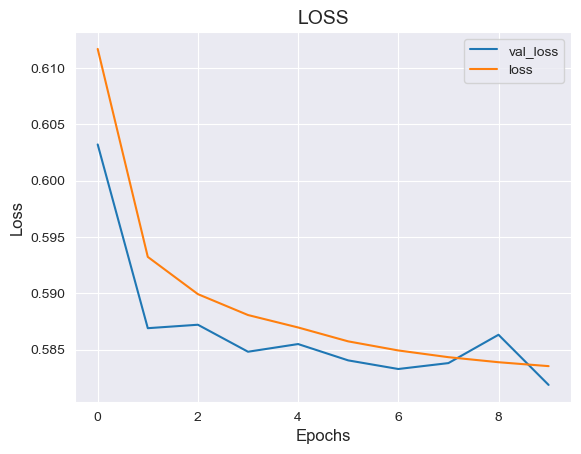

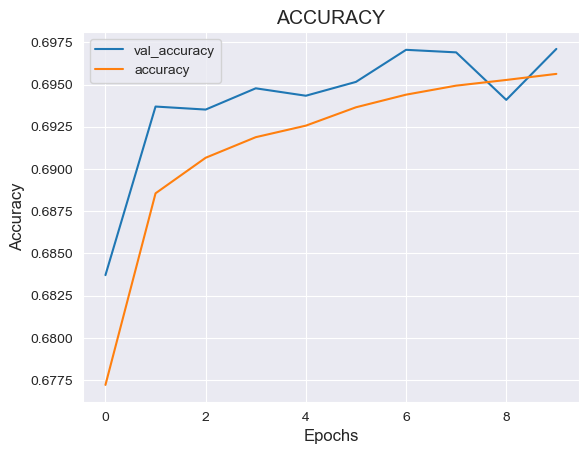

In [21]:
visualize_training_results(results4)

In [22]:
y_pred_m4 = model_4.predict(X_test)
y_pred_m4 =(y_pred_m4 > 0.5)

24888/24888 [==============================] - 13s 530us/step


In [23]:
cm_m4 = confusion_matrix(y_test, y_pred_m4)
print(cm_m4)
print("------------------")
print(classification_report(y_test, y_pred_m4))

[[447882  52951]
 [189162 106419]]
------------------
              precision    recall  f1-score   support

         0.0       0.70      0.89      0.79    500833
         1.0       0.67      0.36      0.47    295581

    accuracy                           0.70    796414
   macro avg       0.69      0.63      0.63    796414
weighted avg       0.69      0.70      0.67    796414



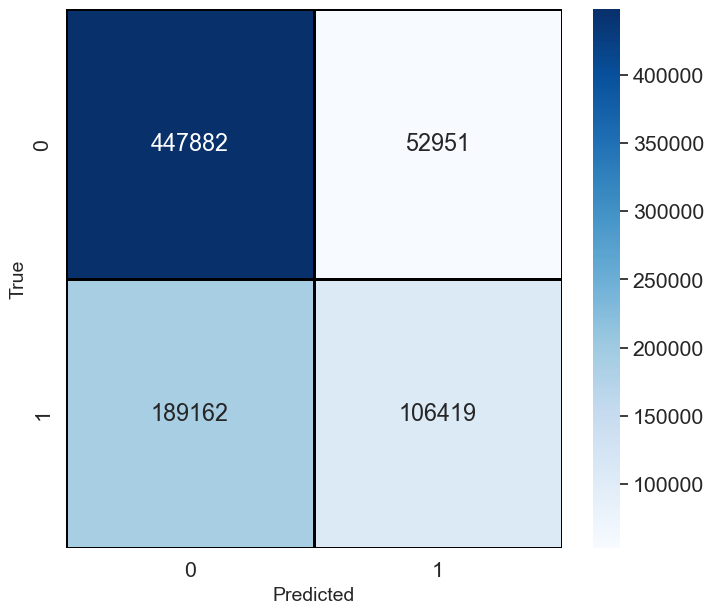

In [24]:
conf_matrix(cm_m4)

In [25]:
model_metrics(y_test, y_pred_m4)

Accuracy: 69.6 %
Precision score: 66.77 %
Recall score: 36.0 %
F1 score: 46.78 %


## Model 5

In [26]:
model_5 = Sequential()

model_5.add(Dense(30, activation='relu', input_shape=(62,)))

model_5.add(Dense(10, activation='relu'))

#model_5.add(Dense(5, activation='relu'))

model_5.add(Dense(1, activation='sigmoid'))

In [27]:
model_5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
results5 = model_5.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
89597/89597 [==============================] - 69s 765us/step - loss: 0.6201 - accuracy: 0.6818 - val_loss: 0.5938 - val_accuracy: 0.6881
Epoch 2/10
89597/89597 [==============================] - 68s 764us/step - loss: 0.5918 - accuracy: 0.6892 - val_loss: 0.5882 - val_accuracy: 0.6937
Epoch 3/10
89597/89597 [==============================] - 67s 748us/step - loss: 0.5889 - accuracy: 0.6918 - val_loss: 0.5854 - val_accuracy: 0.6944
Epoch 4/10
89597/89597 [==============================] - 67s 748us/step - loss: 0.5876 - accuracy: 0.6925 - val_loss: 0.5838 - val_accuracy: 0.6959
Epoch 5/10
89597/89597 [==============================] - 68s 761us/step - loss: 0.5867 - accuracy: 0.6930 - val_loss: 0.5887 - val_accuracy: 0.6910
Epoch 6/10
89597/89597 [==============================] - 68s 761us/step - loss: 0.5861 - accuracy: 0.6938 - val_loss: 0.5829 - val_accuracy: 0.6964
Epoch 7/10
89597/89597 [==============================] - 68s 764us/step - loss: 0.5854 - accuracy: 0.6940

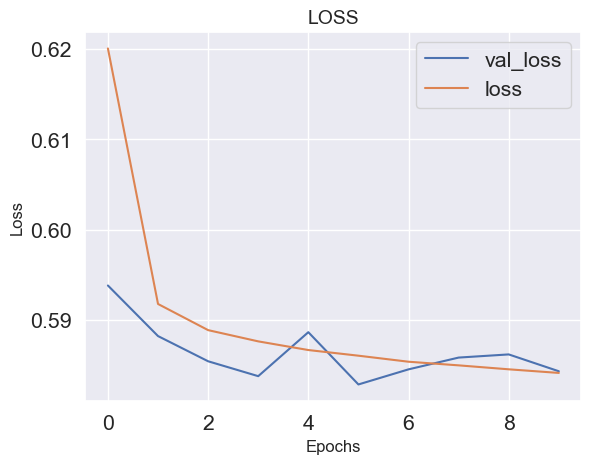

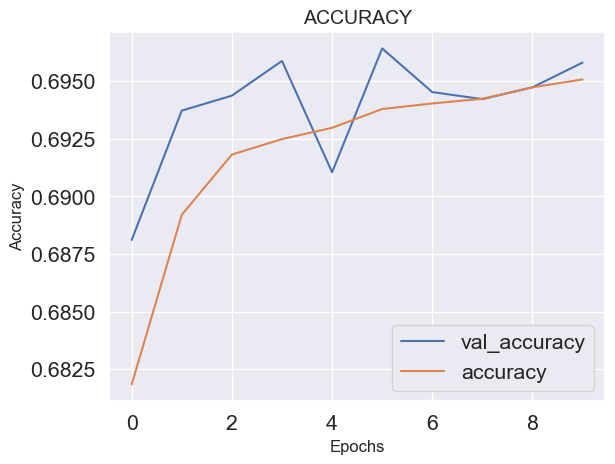

In [29]:
visualize_training_results(results5)

In [30]:
y_pred_m5 = model_5.predict(X_test)
y_pred_m5 =(y_pred_m5 > 0.5)

24888/24888 [==============================] - 13s 534us/step


In [31]:
cm_m5 = confusion_matrix(y_test, y_pred_m5)
print(cm_m5)
print("------------------")
print(classification_report(y_test, y_pred_m5))

[[437460  63373]
 [179839 115742]]
------------------
              precision    recall  f1-score   support

         0.0       0.71      0.87      0.78    500833
         1.0       0.65      0.39      0.49    295581

    accuracy                           0.69    796414
   macro avg       0.68      0.63      0.64    796414
weighted avg       0.69      0.69      0.67    796414



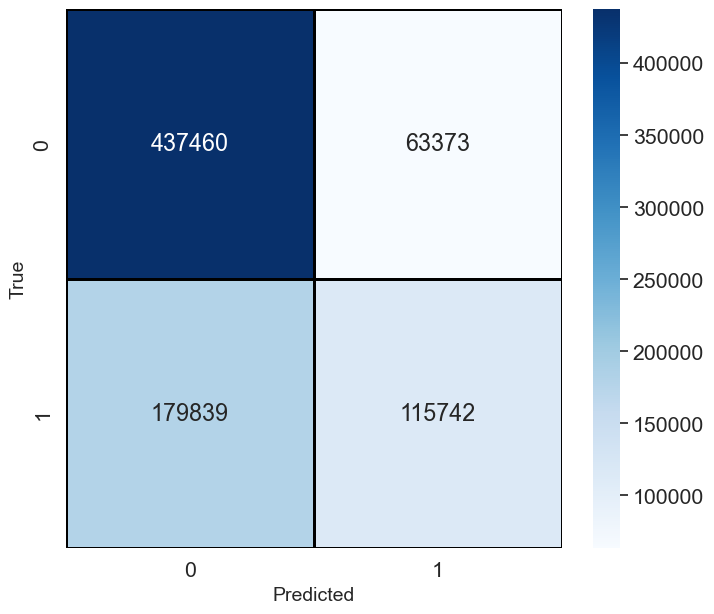

In [32]:
conf_matrix(cm_m5)

In [33]:
model_metrics(y_test, y_pred_m5)

Accuracy: 69.46 %
Precision score: 64.62 %
Recall score: 39.16 %
F1 score: 48.76 %


=========================================================================================

<b>FROM HERE ONWARDS THE MODELS HAVE A DIFFERENT SET OF FEATURES WITH ALL THE MONTHS BEING DROPPED. AFTER DOING A FEATURE SELECTION IT WAS CLEAR THAT THESE WOULD NOT HAVE ANY RELEVANCE IN THE MODEL AND THEREFORE WOULD CAUSE NOISE.

=========================================================================================

In [34]:
y = df['FLIGHT_STATUS']
X = df.drop(['FLIGHT_STATUS', 'DEP_DELAY', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12'], axis=1)

## Model 6

In [35]:
model_6 = Sequential()

model_6.add(Dense(50, activation='relu', input_shape=(62,)))

model_6.add(Dense(30, activation='relu'))

model_6.add(Dense(15, activation='relu'))

model_6.add(Dense(1, activation='sigmoid'))

model_6.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 50)                3150      
                                                                 
 dense_8 (Dense)             (None, 30)                1530      
                                                                 
 dense_9 (Dense)             (None, 15)                465       
                                                                 
 dense_10 (Dense)            (None, 1)                 16        
                                                                 
Total params: 5,161
Trainable params: 5,161
Non-trainable params: 0
_________________________________________________________________


In [36]:
model_6.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
results6 = model_6.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
89597/89597 [==============================] - 71s 780us/step - loss: 0.6070 - accuracy: 0.6820 - val_loss: 0.5877 - val_accuracy: 0.6913
Epoch 2/5
89597/89597 [==============================] - 72s 804us/step - loss: 0.5902 - accuracy: 0.6904 - val_loss: 0.5960 - val_accuracy: 0.6866
Epoch 3/5
89597/89597 [==============================] - 71s 797us/step - loss: 0.5882 - accuracy: 0.6920 - val_loss: 0.5851 - val_accuracy: 0.6962
Epoch 4/5
89597/89597 [==============================] - 72s 805us/step - loss: 0.5870 - accuracy: 0.6931 - val_loss: 0.5843 - val_accuracy: 0.6959
Epoch 5/5
89597/89597 [==============================] - 74s 826us/step - loss: 0.5860 - accuracy: 0.6935 - val_loss: 0.5846 - val_accuracy: 0.6964


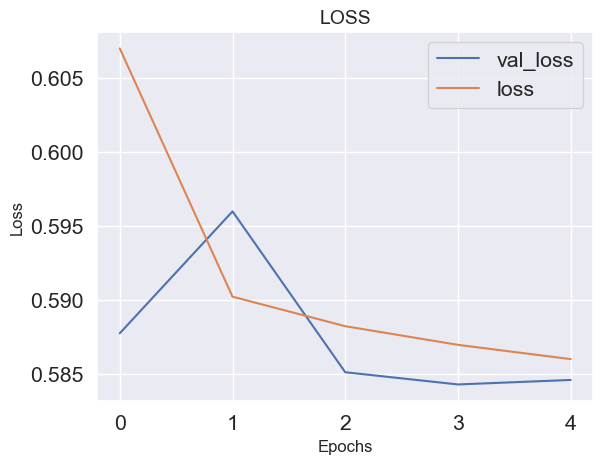

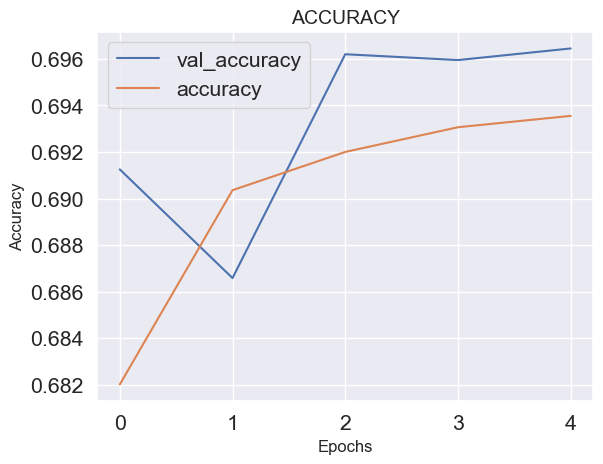

In [38]:
visualize_training_results(results6)

In [39]:
y_pred_m6 = model_6.predict(X_test)
y_pred_m6 =(y_pred_m6 > 0.5)

24888/24888 [==============================] - 14s 577us/step


In [40]:
cm_m6 = confusion_matrix(y_test, y_pred_m6)
print(cm_m6)
print("------------------")
print(classification_report(y_test, y_pred_m6))

[[441744  59089]
 [183382 112199]]
------------------
              precision    recall  f1-score   support

         0.0       0.71      0.88      0.78    500833
         1.0       0.66      0.38      0.48    295581

    accuracy                           0.70    796414
   macro avg       0.68      0.63      0.63    796414
weighted avg       0.69      0.70      0.67    796414



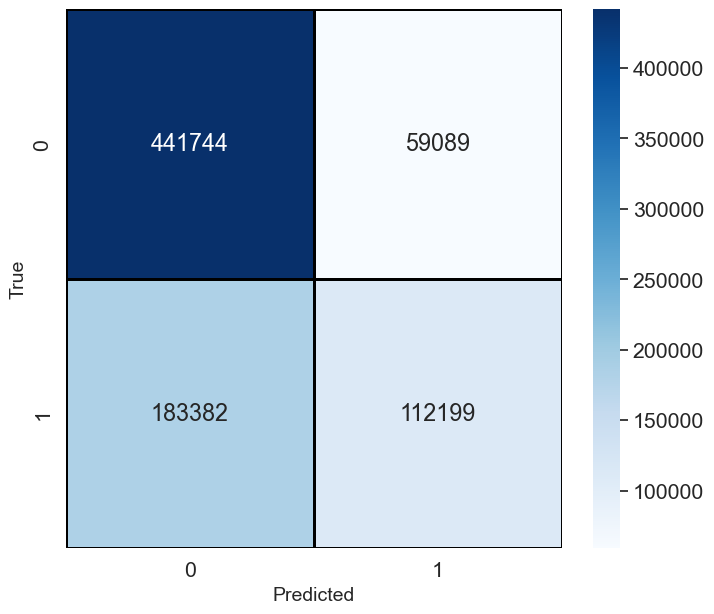

In [41]:
conf_matrix(cm_m6)

In [42]:
model_metrics(y_test, y_pred_m6)

Accuracy: 69.55 %
Precision score: 65.5 %
Recall score: 37.96 %
F1 score: 48.06 %


# Model 7

In [43]:
model_7 = Sequential()

model_7.add(Dense(50, activation='relu', input_shape=(62,)))

model_7.add(Dense(40, activation='relu'))

model_7.add(Dense(25, activation='relu'))

model_7.add(Dense(5, activation='relu'))

model_7.add(Dense(1, activation='sigmoid'))

model_7.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 50)                3150      
                                                                 
 dense_12 (Dense)            (None, 40)                2040      
                                                                 
 dense_13 (Dense)            (None, 25)                1025      
                                                                 
 dense_14 (Dense)            (None, 5)                 130       
                                                                 
 dense_15 (Dense)            (None, 1)                 6         
                                                                 
Total params: 6,351
Trainable params: 6,351
Non-trainable params: 0
_________________________________________________________________


In [44]:
model_7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
results7 = model_7.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
89597/89597 [==============================] - 77s 851us/step - loss: 0.6598 - accuracy: 0.6287 - val_loss: 0.6592 - val_accuracy: 0.6296
Epoch 2/5
89597/89597 [==============================] - 73s 809us/step - loss: 0.6596 - accuracy: 0.6287 - val_loss: 0.6592 - val_accuracy: 0.6296
Epoch 3/5
89597/89597 [==============================] - 76s 845us/step - loss: 0.6596 - accuracy: 0.6287 - val_loss: 0.6592 - val_accuracy: 0.6296
Epoch 4/5
89597/89597 [==============================] - 73s 812us/step - loss: 0.6596 - accuracy: 0.6287 - val_loss: 0.6593 - val_accuracy: 0.6296
Epoch 5/5
89597/89597 [==============================] - 73s 820us/step - loss: 0.6596 - accuracy: 0.6287 - val_loss: 0.6592 - val_accuracy: 0.6296


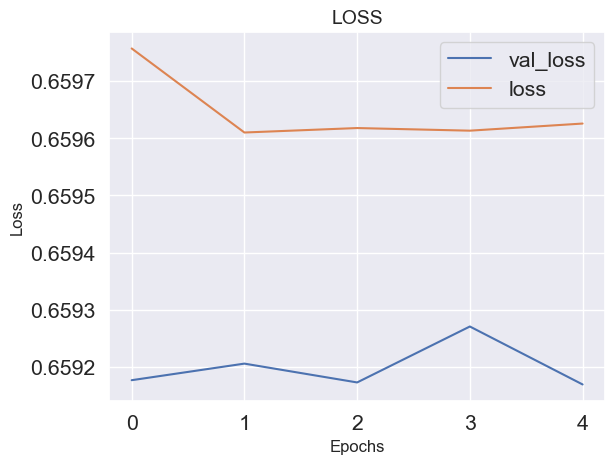

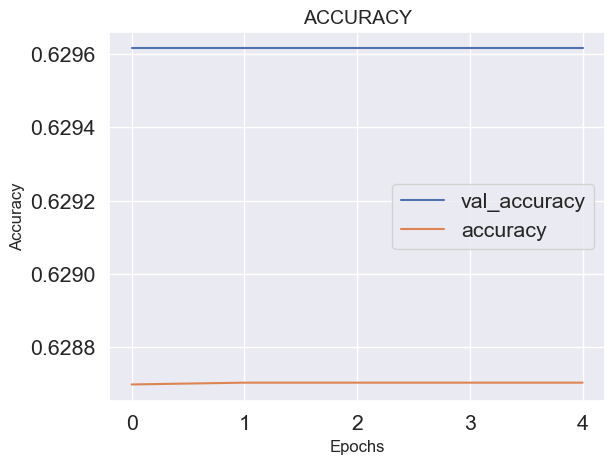

In [46]:
visualize_training_results(results7)

In [47]:
y_pred_m7 = model_7.predict(X_test)
y_pred_m7 =(y_pred_m7 > 0.5)

24888/24888 [==============================] - 14s 565us/step


In [48]:
cm_m7 = confusion_matrix(y_test, y_pred_m7)
print(cm_m7)
print("------------------")
print(classification_report(y_test, y_pred_m7))

[[500833      0]
 [295581      0]]
------------------
              precision    recall  f1-score   support

         0.0       0.63      1.00      0.77    500833
         1.0       0.00      0.00      0.00    295581

    accuracy                           0.63    796414
   macro avg       0.31      0.50      0.39    796414
weighted avg       0.40      0.63      0.49    796414



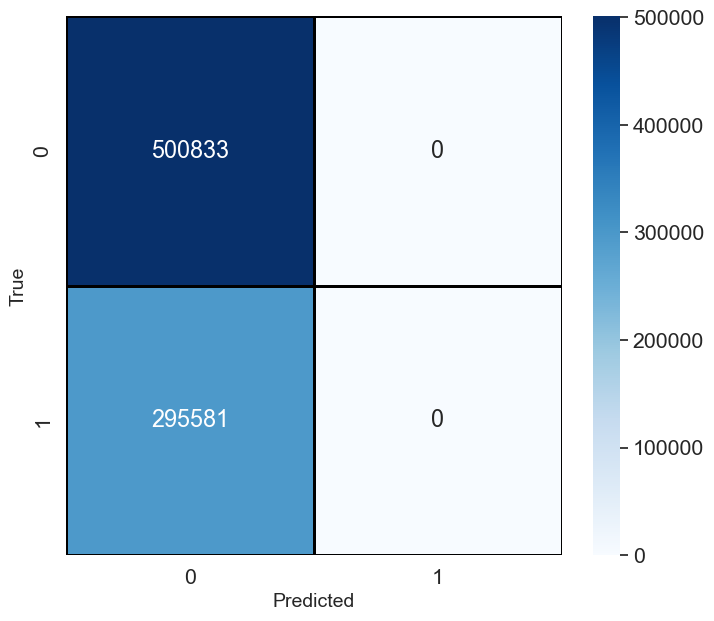

In [49]:
conf_matrix(cm_m7)

In [50]:
model_metrics(y_test, y_pred_m7)

Accuracy: 62.89 %
Precision score: 0.0 %
Recall score: 0.0 %
F1 score: 0.0 %
